In [240]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time
import re

In [2]:
# 解决matplotlib中文乱码

matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

## 前提
有一天，你的运营同事找到你，说京东电商平台最近小家电类目的订单数量、产品浏览量、搜索数量等都有所下降， 现在部门计划对小家电类目进行一次季末促销活动，希望你能针对小家电的用户特征给出一些建议。

# 数据合并
2020年8月13日-8月19日
小家电类目订单数据

In [3]:
order_df = pd.read_csv("xjd_order_d.csv", sep='\t', encoding="utf-8", dtype=str)
user_df = pd.read_csv("xjd_user_info.csv", sep='\t',encoding="utf-8", dtype=str)
user_cart_df = pd.read_csv("xjd_user_cart.csv", sep='\t', encoding="utf-8", dtype=str)

In [4]:
# 查看数据缺失情况
order_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607712 entries, 0 to 607711
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_log_acct            607712 non-null  object
 1   parent_sale_ord_id       607712 non-null  object
 2   sale_ord_id              607712 non-null  object
 3   sale_ord_tm              607712 non-null  object
 4   sale_ord_dt              607712 non-null  object
 5   item_sku_id              607712 non-null  object
 6   item_name                607712 non-null  object
 7   brandname                607712 non-null  object
 8   sale_qtty                607712 non-null  object
 9   item_first_cate_name     607712 non-null  object
 10  item_second_cate_name    607712 non-null  object
 11  item_third_cate_name     607712 non-null  object
 12  before_prefr_unit_price  607712 non-null  object
 13  after_prefr_unit_price   607712 non-null  object
 14  user_actual_pay_amou

In [5]:
# change data type

order_df['sale_qtty'] = order_df['sale_qtty'].astype('int') # 商品数量
order_df['sale_ord_valid_flag'] = order_df['sale_ord_valid_flag'].astype('int') # 订单有效标志
order_df['cancel_flag'] = order_df['cancel_flag'].astype('int')  #订单取消标志
order_df['self_ord_flag'] = order_df['self_ord_flag'].astype('int') # 自营标志

order_df['before_prefr_unit_price'] = order_df['before_prefr_unit_price'].astype('float')
order_df['after_prefr_unit_price'] = order_df['after_prefr_unit_price'].astype('float')
order_df['user_actual_pay_amount'] = order_df['user_actual_pay_amount'].astype('float')
order_df['total_offer_amount'] = order_df['total_offer_amount'].astype('float')

order_df.loc[:,'check_account_tm '] = pd.to_datetime(order_df.loc[:,'check_account_tm'])
order_df.loc[:,'sale_ord_tm'] = pd.to_datetime(order_df.loc[:,'sale_ord_tm'])
order_df.loc[:,'sale_ord_dt'] = pd.to_datetime(order_df.loc[:,'sale_ord_dt'])

In [6]:
# missing values
order_df.isnull().sum().sort_values(ascending = False)

user_site_city_id          177620
user_site_province_id      177488
check_account_tm           100207
check_account_tm           100207
item_third_cate_name            0
parent_sale_ord_id              0
sale_ord_id                     0
sale_ord_tm                     0
sale_ord_dt                     0
item_sku_id                     0
item_name                       0
brandname                       0
sale_qtty                       0
item_first_cate_name            0
item_second_cate_name           0
after_prefr_unit_price          0
before_prefr_unit_price         0
wait_check_account_flag         0
user_actual_pay_amount          0
sale_ord_valid_flag             0
cancel_flag                     0
total_offer_amount              0
self_ord_flag                   0
user_lv_cd                      0
rev_addr_province_id            0
rev_addr_city_id                0
user_log_acct                   0
dtype: int64

In [7]:
order_df.head(3)

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,check_account_tm,total_offer_amount,self_ord_flag,user_site_city_id,user_site_province_id,user_lv_cd,rev_addr_province_id,rev_addr_city_id,wait_check_account_flag,check_account_tm
0,------1289,130704863113,124906164828,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2020-08-18 00:02:25.0,639.4,1,0,0,50,1,2809,0,2020-08-18 00:02:25
1,------1289,130704863113,124903359952,2020-08-18 00:02:10,2020-08-18,4559760,德尔玛（Deerma） 加湿器 5L大容量 家用卧室静音 迷你香薰空气加湿 DEM-F60...,德尔玛（Deerma）,1,家用电器,...,2020-08-18 00:02:25.0,36.8,1,0,0,50,1,2809,0,2020-08-18 00:02:25
2,------1289,130704863113,130704863113,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2020-08-18 00:02:23.0,0.0,1,0,0,50,1,2809,0,2020-08-18 00:02:23


In [8]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215090 entries, 0 to 215089
Data columns (total 39 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   user_log_acct            215090 non-null  object
 1   ulp_base_sex             215090 non-null  object
 2   ulp_base_age             215090 non-null  object
 3   ulp_base_income          215090 non-null  object
 4   ulp_base_education       215090 non-null  object
 5   ulp_base_regprovince     215090 non-null  object
 6   ulp_base_regcity         215090 non-null  object
 7   ulp_user_reg_source_det  0 non-null       object
 8   ulp_user_reg_days        215090 non-null  object
 9   ulp_base_regtime         215090 non-null  object
 10  ulp_base_ulevel          215090 non-null  object
 11  ulp_jd_jx_value          215090 non-null  object
 12  ulp_is_plus_member       215090 non-null  object
 13  ulp_is_student_customer  215090 non-null  object
 14  ulp_base_profession 

In [9]:
user_df.head()

,user_log_acct,ulp_base_sex,ulp_base_age,ulp_base_income,ulp_base_education,ulp_base_regprovince,ulp_base_regcity,ulp_user_reg_source_det,ulp_user_reg_days,ulp_base_regtime,...,cvl_glob_values,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag
0,1030914909,0,3,-1,3,-1,闵行区,NaN,3164,2011-12,...,0.6480779,中度-忠诚型,-1.0,L1-3,L1-4,NaN,0,NaN,2019-06-08 22:18:32.0,1
1,103385299,1,3,-1,4,-1,温州市,NaN,3969,2009-10,...,4.023711,高度-忠诚型,-1.0,L1-4,L1-4,44,0,1991-9-9,2020-08-13 18:32:57.0,0
2,10638747-707577,1,3,-1,3,-1,朝阳区,NaN,2637,2013-05,...,1.6201134,高度-忠诚型,43.38952623913664,L1-2,L1-5,NaN,0,1992-4-3,2020-06-20 17:11:33.0,1
3,1087096-78471807,1,4,-1,4,-1,-1,NaN,3740,2010-05,...,15.702956,高度-忠诚型,-1.0,L1-3,L1-4,NaN,0,2014-1-1,2020-08-13 12:16:12.0,1
4,1090625252_m,1,6,-1,2,-1,-1,NaN,2379,2014-02,...,1.3287612,近期-普通型,-1.0,L1-4,L1-3,NaN,2,NaN,2019-09-28 10:29:32.0,1


In [10]:
user_df["user_log_acct"].nunique()

215090

In [11]:
# 合并order和user表，获取有订单的用户

order_user_df = pd.merge(order_df, user_df, on = 'user_log_acct')
order_user_df.head()

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,cvl_glob_values,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag
0,------1289,130704863113,124906164828,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
1,------1289,130704863113,124903359952,2020-08-18 00:02:10,2020-08-18,4559760,德尔玛（Deerma） 加湿器 5L大容量 家用卧室静音 迷你香薰空气加湿 DEM-F60...,德尔玛（Deerma）,1,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
2,------1289,130704863113,130704863113,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
3,------1289,130699964163,130699964163,2020-08-18 00:00:16,2020-08-18,100011967276,爱丽思(IRIS OHYAMA)日本 吸尘器 无线家用充电手持轻便智能吸尘机IC-SDC2C（粉）,IRIS OHYAMA,3,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
4,------1289,130704863113,124903359952,2020-08-18 00:02:10,2020-08-18,100006533674,德尔玛（Deerma）加湿器净水盒 水箱专用 通用 银离子净水盒,德尔玛（Deerma）,1,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0


In [12]:
order_user_df.shape

(607712, 65)

In [13]:
# 对下过订单的用户，以用户ID进行去重，保留重复数据的第一个
user_info_df = order_user_df.drop_duplicates(subset = ["user_log_acct"],keep = "first")

In [14]:
user_info_df

,user_log_acct,parent_sale_ord_id,sale_ord_id,sale_ord_tm,sale_ord_dt,item_sku_id,item_name,brandname,sale_qtty,item_first_cate_name,...,cvl_glob_values,cvl_glob_loyalty,cvl_glob_platform,cfv_sens_promotion,cfv_sens_comment,reg_user_type_cd,member_reg_gender,reg_birthday,last_login_tm,factory_user_flag
0,------1289,130704863113,124906164828,2020-08-18 00:02:10,2020-08-18,100009149228,飞利浦 (PHILIPS)蒸汽电熨斗家用 熨烫机 GC4902/28,飞利浦（PHILIPS）,2,家用电器,...,2.0375423,高度-忠诚型,77.97380894394887,L1-4,L1-4,1,0,1997-2-10,2020-08-11 22:55:05.0,0
7,---刺猬,130744622338,130744622338,2020-08-18 18:11:35,2020-08-18,100001679413,安吉尔（Angel）茶吧机立式家用办公室饮水机多功能自动上水柜式茶吧机下置水桶式CB2705...,安吉尔（Angel）,1,家用电器,...,1.8591628,高度-忠诚型,79.13798834497094,L1-2,L1-5,NaN,2,NaN,2019-12-11 18:29:44.0,1
10,--寂,124775599894,124775599894,2020-08-15 12:49:06,2020-08-15,2392546,赛亿（Shinee）小风扇 台扇/台夹扇 壁扇 迷你静音学生宿舍床头办公室桌面换气电风扇FJ...,赛亿（Shinee）,1,家用电器,...,3.1875074,高度-忠诚型,-1.0,L1-4,L1-5,NaN,2,NaN,2020-02-25 15:01:41.0,1
13,-love明-,130503457517,130501451054,2020-08-15 19:47:49,2020-08-15,3085665,松下（Panasonic）吸尘器MC-WF350手持式真空吸尘器家用超大吸力手提式系列吸尘器...,松下（Panasonic）,1,家用电器,...,9.721487,高度-忠诚型,69.12535255785926,L1-4,L1-5,NaN,0,1988-1-17,2020-08-08 20:34:47.0,1
16,-zhongzhong,124778603709,130550058117,2020-08-15 12:53:08,2020-08-15,100012373764,格力 （GREE）新品家用智能遥控定时电风扇/塔式落地扇/直流变频电扇/立式塔扇/无叶风扇F...,格力（GREE）,1,家用电器,...,18.505648,高度-忠诚型,63.646321011381815,L1-3,L1-5,NaN,0,1986-10-22,2020-08-12 14:24:47.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607704,龙龙豆豆1988,124905744754,124905744754,2020-08-18 01:43:56,2020-08-18,5149337,碧然德（BRITA）家用净水壶 滤水壶滤芯 MAXTRA+LE 去水垢专家滤芯 6枚装,碧然德,3,家用电器,...,6.1628323,高度-忠诚型,85.79622152813988,L1-4,L1-5,NaN,1,1988-12-13,2020-08-06 10:15:03.0,1
607706,龚凤波,124863599292,124863599292,2020-08-17 08:13:19,2020-08-17,100005221904,康佳（KONKA）大型家用商用空调扇 制冷风扇 冷风机 冷风扇 车间食堂餐厅网吧大排档移动工...,康佳（KONKA）,1,家用电器,...,3.9117951,高度-忠诚型,-1.0,L1-2,L1-3,1,2,NaN,2017-04-28 14:18:32.0,0
607707,龚天睿,124772876191,124772404564,2020-08-15 11:03:24,2020-08-15,5149351,碧然德（BRITA）家用净水壶 滤水壶滤芯 MAXTRA+LE 去水垢专家滤芯 3枚装,碧然德,1,家用电器,...,2.4423106,高度-忠诚型,74.56211872975473,L1-4,L1-5,NaN,0,2011-1-1,2019-12-04 22:35:59.0,1
607710,龚思嘉,124875168188,124875168188,2020-08-17 12:35:34,2020-08-17,4460778,沁园（TRULIVA）家用净水器 即滤型超滤机 长寿命滤芯 无废水 矿物质净水机 QJ-UF...,沁园（TRULIVA）,1,家用电器,...,7.002889,高度-忠诚型,15.897319691476284,L1-4,L1-5,NaN,0,0001-1-1,2019-11-02 09:57:09.0,1


# 用户基本属性

## 性别分布

在全部订单中，只要下过单的用户（无论订单是否有效），都计算在内

In [79]:
user_sex_df = user_info_df.groupby(["ulp_base_sex"],as_index=False)["user_log_acct"].agg({'ulp_base_sex_count':'count'})
user_sex_df

,ulp_base_sex,ulp_base_sex_count
0,-1,2164
1,0,95974
2,1,116952


In [80]:
female_user = user_sex_df['ulp_base_sex_count'][1] # 女性用户
male_user = user_sex_df['ulp_base_sex_count'][2] # 男性用户

Text(0.5, 1.0, '小家电消费用户的性别分布')

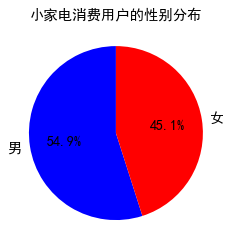

In [81]:
labels = ["男","女"]
colors = ["b","r"]
plt.pie([male_user,female_user], autopct = "%1.1f%%", labels = labels, 
       startangle = 90, colors = colors, textprops = {"fontsize":14})
plt.title("小家电消费用户的性别分布")

## 用户年龄分布

In [84]:
# age每一个数字代表一个年龄区间
user_age_df = user_info_df.groupby(["ulp_base_age"],as_index=False)["user_log_acct"].agg({'user_age_count':'count'})
user_age_df['ulp_base_age'] = user_age_df['ulp_base_age'].astype('int')
user_age_df = user_age_df[user_age_df.ulp_base_age>-1]
user_age_df

,ulp_base_age,user_age_count
1,1,21
2,2,27947
3,3,105501
4,4,56682
5,5,12177
6,6,11074


In [85]:
x = ['18岁以下', '18~25岁',  '25~35岁', '35~45岁', '45~55岁', '55岁以上']
y = user_age_df['user_age_count']

<BarContainer object of 6 artists>

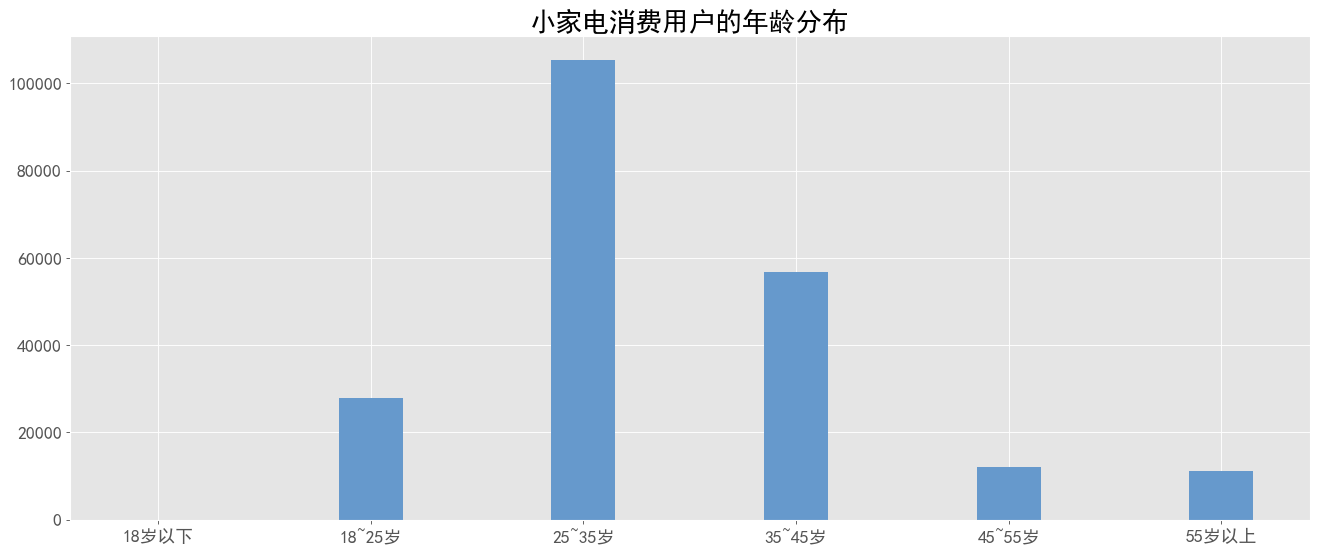

In [86]:
plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')

plt.title("小家电消费用户的年龄分布", size=24) # 图标题

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.bar(x, y, width=0.3, color='#6699CC')

### 性别x年龄分布

In [22]:
age_gender_df = user_info_df.groupby(["ulp_base_age","ulp_base_sex"],as_index=False)["user_log_acct"].agg({'user_gender_age_count':'count'})
age_gender_df["ulp_base_age"] = age_gender_df["ulp_base_age"].astype(int)
age_gender_df

,ulp_base_age,ulp_base_sex,user_gender_age_count
0,-1,-1,1225
1,-1,0,219
2,-1,1,244
3,1,0,8
4,1,1,13
5,2,-1,201
6,2,0,11590
7,2,1,16156
8,3,-1,299
9,3,0,49258


In [23]:
# 去掉为年龄组为-1的部分
i = age_gender_df[age_gender_df.ulp_base_age == -1].index
age_gender_df.drop(i, axis = 0, inplace = True)

In [24]:
# 获取统计数据（按性别）
female = age_gender_df[age_gender_df.ulp_base_sex == "0"][["ulp_base_age","user_gender_age_count"]]
male =  age_gender_df[age_gender_df.ulp_base_sex == "1"][["ulp_base_age","user_gender_age_count"]]

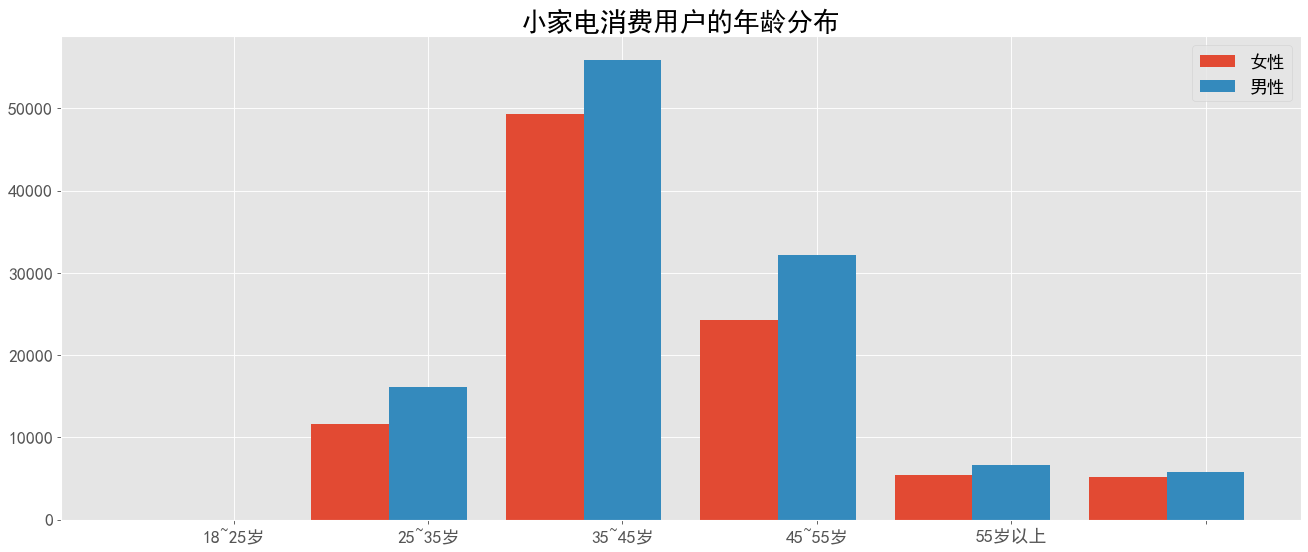

In [25]:
fig = plt.figure(figsize=(20, 8), dpi=80)
ax = fig.add_subplot(111)

ax.bar(female["ulp_base_age"]-0.4,female["user_gender_age_count"], width=0.4,align='center')
ax.bar(male["ulp_base_age"], male["user_gender_age_count"], width=0.4,align='center')
ax.set_xticklabels(x, size = 16)
ax.set_yticklabels([0,10000,20000,30000,40000,50000],size = 16)
ax.set_title("小家电消费用户的年龄分布", size=24)
ax.legend(('女性', '男性'),prop={'size': 16})

## 用户地域分布

In [26]:
user_region_df = user_info_df.groupby('ulp_addr_province', as_index=False)['user_log_acct'].agg({'region_count':'count'})
user_region_df.columns = ['province_name','region_count']
user_region_df = user_region_df.sort_values(by='region_count', ascending=False)
user_region_df

,province_name,region_count
12,广东,35247
15,江苏,19370
4,北京,19214
1,上海,14627
10,山东,14391
6,四川,11003
21,湖北,9504
19,浙江,9455
17,河北,8147
27,辽宁,7023


In [27]:
i = user_region_df[user_region_df.province_name == "-1"].index
user_region_df.drop(i,axis = 0, inplace = True)

In [28]:
user_region_df["province_name"].nunique()

31

In [29]:
# 用to_csv(...encoding = "utf-8")导致了乱码
# 在tableau进行了可视化
user_region_df.to_excel("user_region_df.xlsx", encoding = "utf-8")

In [30]:
x = user_region_df['province_name'][::-1]  # 切片方法，让列表反向。两个冒号分隔为{起始位置：终止位置：步长}
y = user_region_df['region_count'][::-1]  # 其中步长为正，从左往右取，步长为负，从右往左取

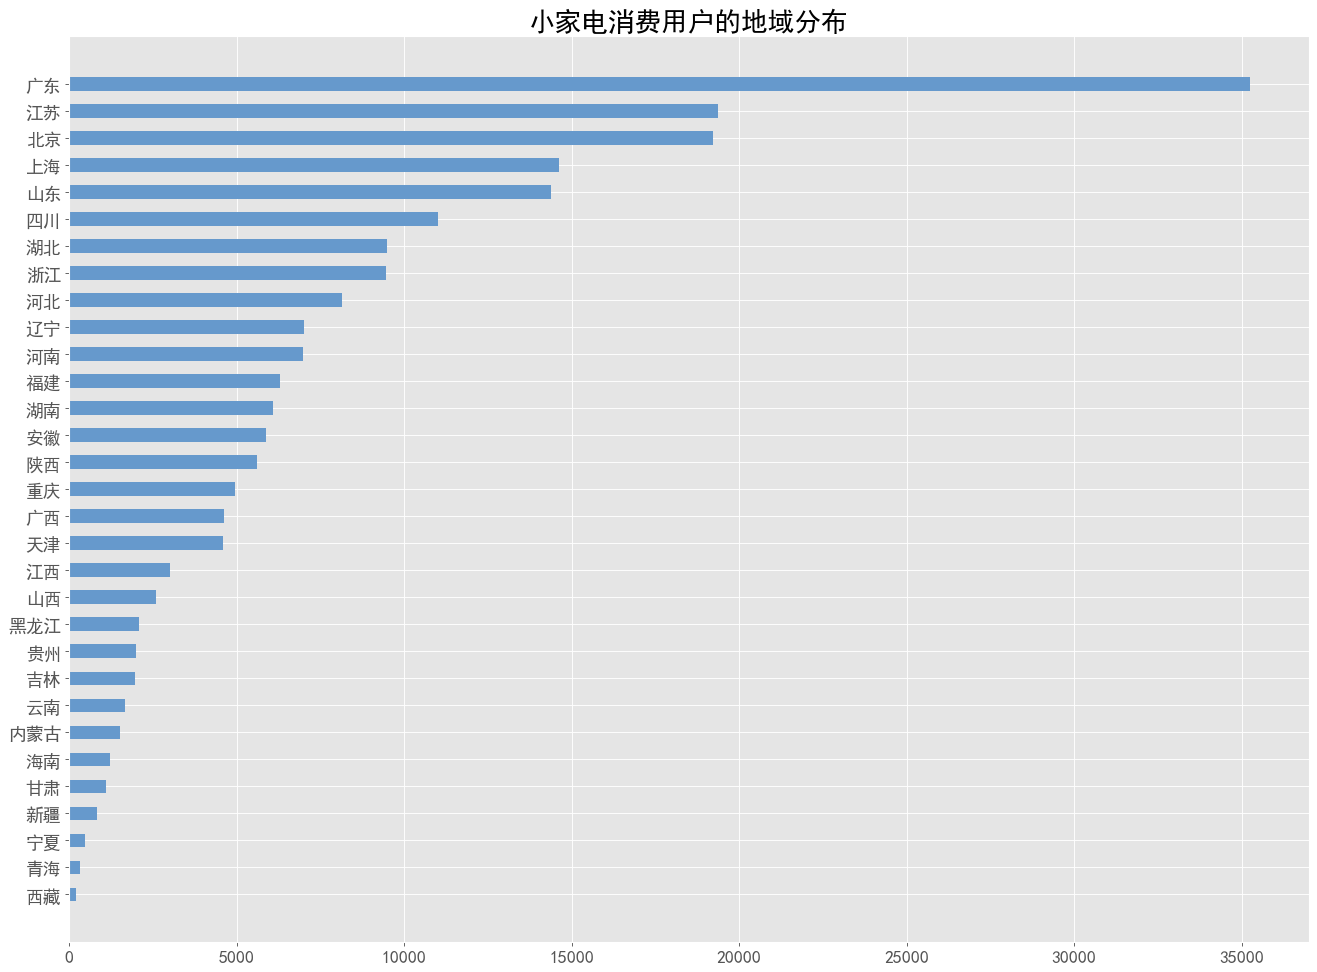

In [31]:
plt.figure(figsize=(20,15), dpi=80)

plt.title("小家电消费用户的地域分布", size=24) # 图标题

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.barh(x, y, height=0.5, color='#6699CC')

plt.show()

## 小家电消费用户的城市分布

In [32]:
user_city_df = user_info_df.groupby('ulp_addr_city', as_index=False)['user_log_acct'].agg({'city_count':'count'}).sort_values(by='city_count', ascending=False)
user_city_df

,ulp_addr_city,city_count
50,北京市,19214
6,上海市,14627
128,广州市,9674
217,深圳市,8839
146,成都市,6788
...,...,...
305,那曲地区,5
353,黄南藏族自治州,4
247,白沙黎族自治县,4
257,神农架林区,4


In [33]:
# 头部城市
user_city_df = user_city_df[:10]
user_city_df

,ulp_addr_city,city_count
50,北京市,19214
6,上海市,14627
128,广州市,9674
217,深圳市,8839
146,成都市,6788
269,苏州市,5754
188,武汉市,5538
313,重庆市,4943
94,天津市,4585
343,青岛市,3786


In [34]:
x = user_city_df['ulp_addr_city'][::-1]
y = user_city_df['city_count'][::-1]

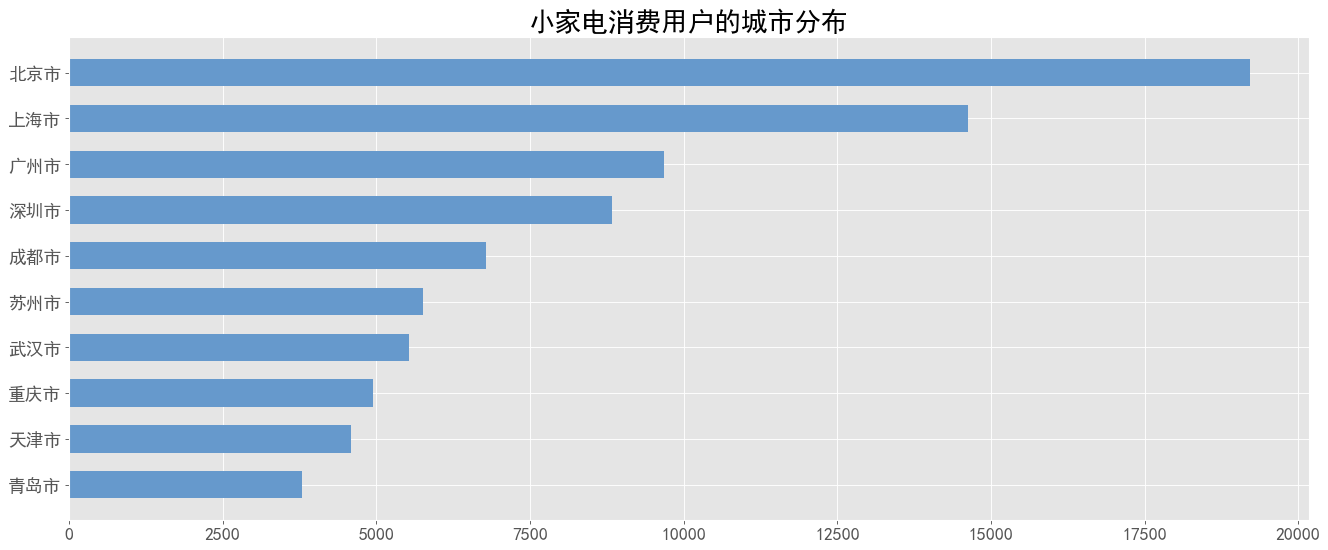

In [35]:
plt.figure(figsize=(20,8),dpi=80)

plt.title("小家电消费用户的城市分布", size=24) # 图标题

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.barh(x, y, align='center', height=0.6, color='#6699CC') # height是水平条形图宽度

plt.show()

## 用户的婚育状况

In [36]:
user_marriage_df = user_info_df.groupby('ulp_base_marriage', as_index=False)['user_log_acct']\
    .agg({'marriage': 'count'})\
    .sort_values(by='marriage', ascending=False)
user_marriage_df

,ulp_base_marriage,marriage
2,1,143755
1,0,65802
0,-1,5533


In [37]:
married_user = user_marriage_df['marriage'].iloc[0] # 取第0行
unmarried_user = user_marriage_df['marriage'].iloc[1] # 取第1行

Text(0.5, 1.0, '小家电消费用户的婚姻情况')

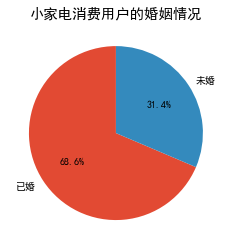

In [38]:
labels = ['已婚', '未婚']
Y = [married_user, unmarried_user]
fig = plt.figure()
plt.pie(Y, labels=labels, autopct='%1.1f%%', startangle=90) # startangle是图旋转角度
plt.title("小家电消费用户的婚姻情况")

## 小家电消费用户的有孩可能性

In [39]:
user_child_df = user_info_df.groupby('ulp_base_child', as_index=False)['user_log_acct']\
                .agg({'child':'count'})\
                .sort_values(by='child', ascending=False)
user_child_df

,ulp_base_child,child
0,-1,63774
3,较高,58209
4,高,38502
2,较低,29468
1,低,25137


In [40]:
user_child_df = user_child_df[user_child_df['ulp_base_child'] != '-1']
user_child_df

,ulp_base_child,child
3,较高,58209
4,高,38502
2,较低,29468
1,低,25137


In [41]:
very_high = user_child_df['child'].iloc[1] # 高，取第1行
high = user_child_df['child'].iloc[0] # 较高，取第0行
low = user_child_df['child'].iloc[2] # 较低，取第2行
very_low = user_child_df['child'].iloc[3] # 低，取第3行

Text(0.5, 1.0, '小家电消费用户的有孩可能性')

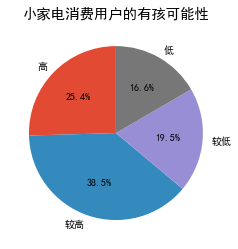

In [42]:
labels = ['高', '较高', '较低', '低']
Y = [very_high, high, low, very_low]
fig = plt.figure()
plt.pie(Y, labels=labels, autopct='%1.1f%%', startangle=90) # startangle是图旋转角度
plt.title("小家电消费用户的有孩可能性")

### 孩子性别

该部分信息无法获取

In [43]:
user_info_df["ulp_seni_childsex"].nunique()

1

### 孩子年龄

In [94]:
child_month_df = user_info_df.groupby("ulp_seni_childage", as_index = False)["user_log_acct"].agg({"childage_count":"count"})
child_month_df = child_month_df[child_month_df["ulp_seni_childage"]>="0"]
child_month_df = child_month_df.sort_values(by = "ulp_seni_childage", ascending = False)
child_month_df

,ulp_seni_childage,childage_count
104,2021-06,2
103,2021-05,2
102,2021-04,15
101,2021-03,312
100,2021-02,555
...,...,...
5,2013-03,70
4,2013-02,80
3,2013-01,86
2,2012-12,72


In [95]:
# 将2020年10月开始的日期视作无效日期
child_month_df = child_month_df[child_month_df.ulp_seni_childage<"2020-10"]
child_month_df.loc["ulp_seni_childage"] = child_month_df["ulp_seni_childage"].astype(str)
child_month_df.shape

D:\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


(96, 2)

In [46]:
# 通过正则表达取出时间（年，月）

child_month_df["year"] = child_month_df["ulp_seni_childage"].str.extract(r'([0-9+]{4})-[0-9]{2}',expand = True)
child_month_df["month"] = child_month_df["ulp_seni_childage"].str.extract(r'[0-9+]{4}-([0-9]{2})',expand = False)
child_month_df.head()

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,ulp_seni_childage,child_count,year,month
95,2020-09,1145.0,2020,09
94,2020-08,1552.0,2020,08
93,2020-07,2176.0,2020,07
92,2020-06,3039.0,2020,06
91,2020-05,3052.0,2020,05


In [47]:
child_month_df.isnull().sum()

ulp_seni_childage    1
child_count          1
year                 1
month                1
dtype: int64

In [48]:
# 去掉NA
child_month_df = child_month_df[~child_month_df.year.isnull()]
child_month_df.isnull().sum()

ulp_seni_childage    0
child_count          0
year                 0
month                0
dtype: int64

In [49]:
# 计算年龄
child_month_df["age"] = 2020-child_month_df["year"].astype(int)+child_month_df["month"].astype(int)*30/365
child_month_df["age"] = round(child_month_df["age"],2)
child_month_df

,ulp_seni_childage,child_count,year,month,age
95,2020-09,1145.0,2020,09,0.74
94,2020-08,1552.0,2020,08,0.66
93,2020-07,2176.0,2020,07,0.58
92,2020-06,3039.0,2020,06,0.49
91,2020-05,3052.0,2020,05,0.41
...,...,...,...,...,...
5,2013-03,70.0,2013,03,7.25
4,2013-02,80.0,2013,02,7.16
3,2013-01,86.0,2013,01,7.08
2,2012-12,72.0,2012,12,8.99


In [50]:
# 分箱
bins = [0,3,6,9,15]
labels = ["3岁及以下","3-6（含）岁", "6-9（含）岁","9岁以上"]
child_month_df["age_range"] = pd.cut(child_month_df["age"],bins = bins,labels = labels)

# groupby
child_age_range_df = child_month_df.groupby("age_range",as_index = False)["child_count"].sum()
child_age_range_df

,age_range,child_count
0,3岁及以下,76551.0
1,3-6（含）岁,22999.0
2,6-9（含）岁,3540.0
3,9岁以上,0.0


Text(0.5, 1.0, '小家电消费用户的孩子年龄分布')

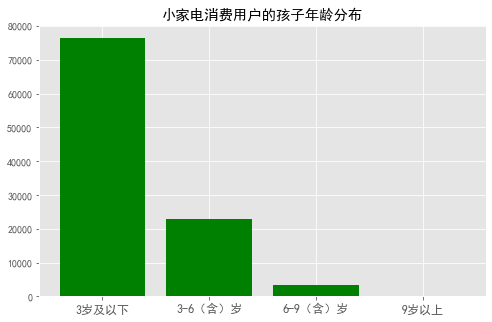

In [51]:
# visualization
fig = plt.figure(figsize = (8,5))
plt.bar(child_age_range_df["age_range"], child_age_range_df["child_count"],color = "g")
plt.xticks(size = 12)
plt.title("小家电消费用户的孩子年龄分布")

In [52]:
child_month_df.year.isnull().sum()

0

In [53]:
child_month_df["year"] = child_month_df["year"].astype(int)

In [54]:
child_month_df.head()

,ulp_seni_childage,child_count,year,month,age,age_range
95,2020-09,1145.0,2020,09,0.74,3岁及以下
94,2020-08,1552.0,2020,08,0.66,3岁及以下
93,2020-07,2176.0,2020,07,0.58,3岁及以下
92,2020-06,3039.0,2020,06,0.49,3岁及以下
91,2020-05,3052.0,2020,05,0.41,3岁及以下


In [55]:
# 将data转化为date格式
#child_month_df.loc["ulp_seni_childage"] = pd.to_datetime(child_month_df["ulp_seni_childage"])
#child_month_df.head()

In [56]:
# 本月
#this_month = datetime.strptime("2020-10-01","%Y-%m-%d")
#child_month_df["age"] = this_month - child_month_df["ulp_seni_childage"]
#child_month_df.head()

In [57]:
child_month_df.dtypes

ulp_seni_childage      object
child_count           float64
year                    int32
month                  object
age                   float64
age_range            category
dtype: object

## 用户的教育水平

In [58]:
user_edu_df = user_info_df.groupby('ulp_base_education', as_index=False)['user_log_acct']\
                .agg({'edu':'count'})\
                .sort_values(by='ulp_base_education', ascending=True)
user_edu_df

,ulp_base_education,edu
0,-1,13872
1,1,3555
2,2,36788
3,3,131534
4,4,29341


In [59]:
user_edu_df = user_edu_df[user_edu_df['ulp_base_education'] != '-1']
user_edu_df

,ulp_base_education,edu
1,1,3555
2,2,36788
3,3,131534
4,4,29341


<BarContainer object of 4 artists>

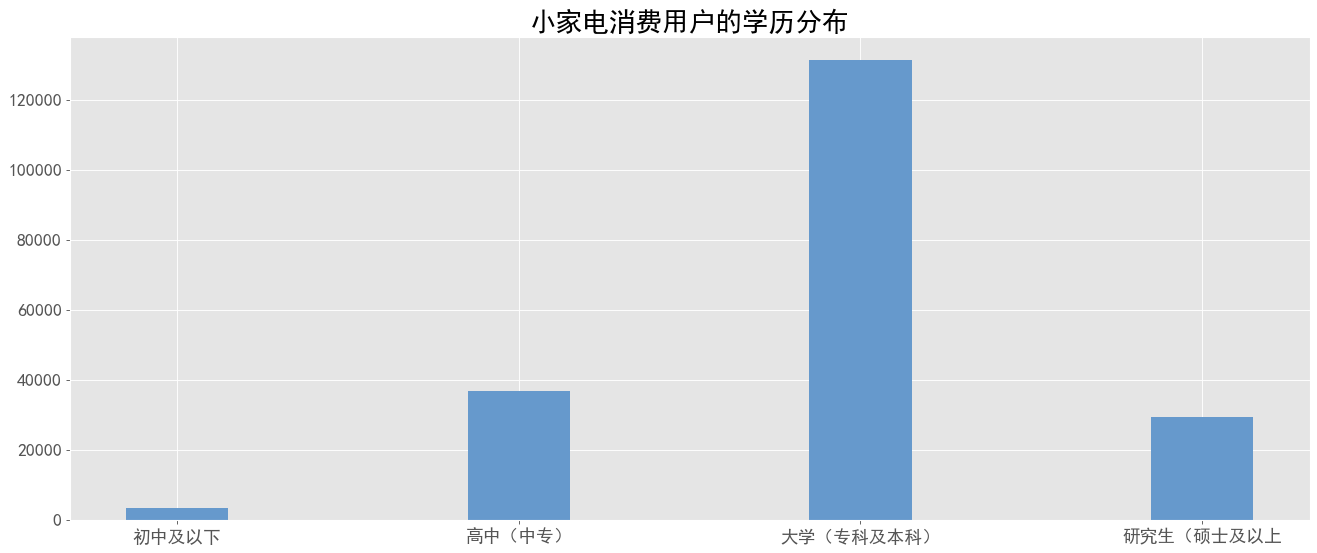

In [60]:
x = ['初中及以下', '高中（中专）', '大学（专科及本科）', '研究生（硕士及以上']
y = user_edu_df['edu']

plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')
plt.title("小家电消费用户的学历分布", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.bar(x, y, width=0.3, color='#6699CC')

## 小家电消费用户的职业分布

In [61]:
user_profession_df = user_info_df.groupby('ulp_base_profession', as_index=False)['user_log_acct']\
                    .agg({'profession':'count'})\
                    .sort_values(by='ulp_base_profession', ascending=True)
user_profession_df

,ulp_base_profession,profession
0,-1,61755
1,a,3492
2,b,4268
3,c,10195
4,d,37080
5,e,14675
6,f,33167
7,g,40932
8,h,9526


In [62]:
user_profession_df = user_profession_df[user_profession_df['ulp_base_profession'] != '-1']
user_profession_df

,ulp_base_profession,profession
1,a,3492
2,b,4268
3,c,10195
4,d,37080
5,e,14675
6,f,33167
7,g,40932
8,h,9526


<BarContainer object of 8 artists>

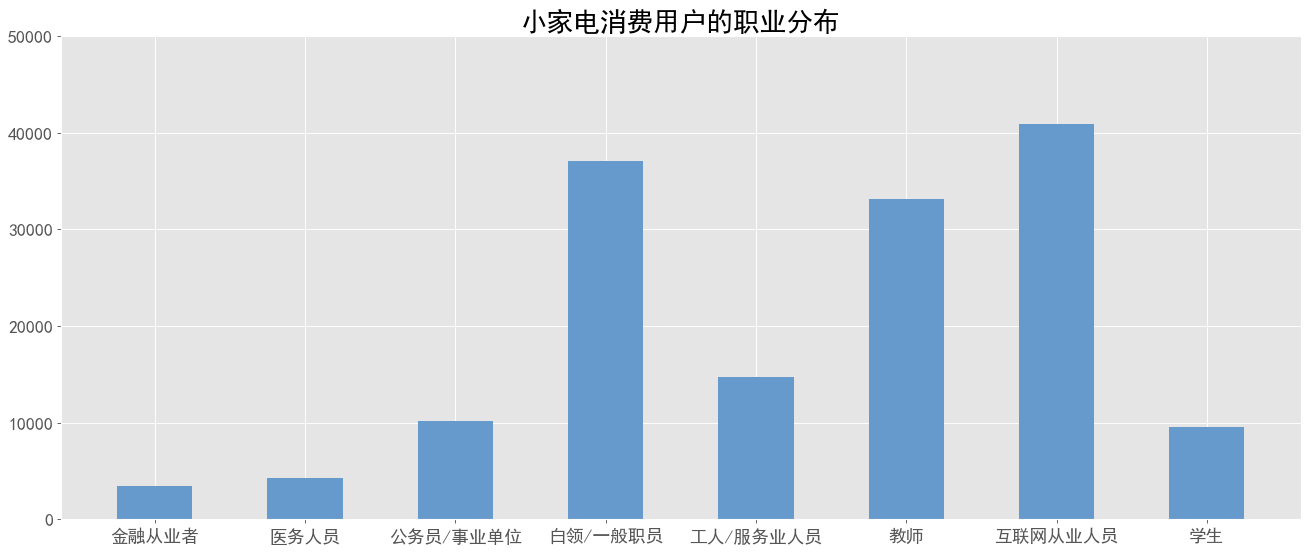

In [63]:
x = ['金融从业者', '医务人员', '公务员/事业单位', '白领/一般职员', '工人/服务业人员', '教师', '互联网从业人员', '学生']
y = user_profession_df['profession']

plt.figure(figsize=(20,8),dpi=80)
plt.style.use('ggplot')
plt.ylim(ymax=50000) # y轴坐标最大值设为50000
plt.title("小家电消费用户的职业分布", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.bar(x, y, width=0.5, color='#6699CC')

## 用户收入

无法获取该部分数据

In [64]:
user_info_df.groupby("ulp_base_income", as_index = False)["user_log_acct"].agg({"income" : "count"})

,ulp_base_income,income
0,-1,215090


## 是否有车

In [98]:
user_car_df = user_info_df.groupby("ulp_seni_hascar", as_index = False)["user_log_acct"].agg({"car_count":"count"})
user_car_df

,ulp_seni_hascar,car_count
0,-1,114522
1,0,30974
2,1,69594


In [101]:
user_car_df = user_car_df[user_car_df.ulp_seni_hascar >="0"]
user_car_df

,ulp_seni_hascar,car_count
1,0,30974
2,1,69594


In [66]:
# 统计人数
have_car = user_car_df["car_count"][1]
no_car = user_car_df["car_count"][2]
total_user = have_car+no_car

# 百分比
user_car_df["percent"] = user_car_df["car_count"]/total_user
user_car_df

,ulp_seni_hascar,car_count,percent
1,0,30974,0.307991
2,1,69594,0.692009


Text(0.5, 1.0, '小家电消费用户私家车拥有率')

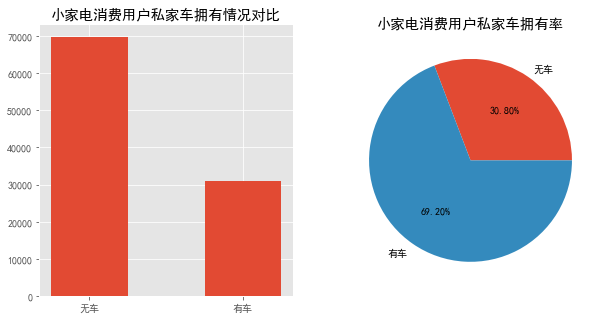

In [67]:
labels = ["无车", "有车"]
plt.figure(figsize = (10,5))

# 柱状图
plt.subplot(121)
plt.bar(labels,[no_car,have_car],width = 0.5)
plt.title("小家电消费用户私家车拥有情况对比")

# 饼图
plt.subplot(122)
plt.pie(user_car_df["percent"],labels = labels, autopct='%1.2f%%')
plt.xticks(size = 14)
plt.title("小家电消费用户私家车拥有率")

## 小家电消费用户画像-基本属性总结

**一位典型小家电消费用户画像：**

他是一位30岁左右的男士，来自一线或新一线城市；

他有着本科学历，在互联网公司就职或是其他行业白领；

他已婚并且有了孩子，孩子在3岁以下；

有一辆代步车；

**推测**

他应该拥比较追求生活品质，注重家庭观念。

但是一线城市节奏快，生活压力大，他可能缺少时间和精力来关注家庭生活。

**结论**

促销的文案可以采用比较中性的风格，突出促销产品对于家庭生活品质的提升。

# 行为属性

In [251]:
# 订单维度的分析， 使用的是有效订单

vaild_order_user_df = order_user_df[(order_user_df['sale_ord_valid_flag'] == 1)
                          &(order_user_df['cancel_flag'] == 0)
                          &(order_user_df['check_account_tm'] != 0)
                          &(order_user_df['before_prefr_unit_price'] != 0)
                          &(order_user_df['user_actual_pay_amount'] != 0)] # 筛选有效订单
vaild_order_user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232599 entries, 9 to 607711
Data columns (total 65 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   user_log_acct            232599 non-null  object        
 1   parent_sale_ord_id       232599 non-null  object        
 2   sale_ord_id              232599 non-null  object        
 3   sale_ord_tm              232599 non-null  datetime64[ns]
 4   sale_ord_dt              232599 non-null  datetime64[ns]
 5   item_sku_id              232599 non-null  object        
 6   item_name                232599 non-null  object        
 7   brandname                232599 non-null  object        
 8   sale_qtty                232599 non-null  int32         
 9   item_first_cate_name     232599 non-null  object        
 10  item_second_cate_name    232599 non-null  object        
 11  item_third_cate_name     232599 non-null  object        
 12  before_prefr_uni

In [328]:
vaild_order_user_df["cvl_glob_values"] = vaild_order_user_df["cvl_glob_values"].astype(float)
vaild_order_user_df["cvl_glob_platform"] = vaild_order_user_df["cvl_glob_platform"].astype(float)

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 小家电(三级商品)购买情况

In [69]:
# 三级商品
user_order_cate_df = vaild_order_user_df.groupby('item_third_cate_name', as_index=False)['sale_ord_id']\
                    .agg({'cate_count':'count'})\
                    .sort_values(by='cate_count', ascending=False)
user_order_cate_df

,item_third_cate_name,cate_count
16,电风扇,74863
2,净水器,39712
20,饮水机,16847
3,加湿器,16240
5,吸尘器,15899
8,挂烫机/熨斗,13008
17,空气净化器,10383
1,冷风扇,9237
7,扫地机器人,8630
15,电话机,6085


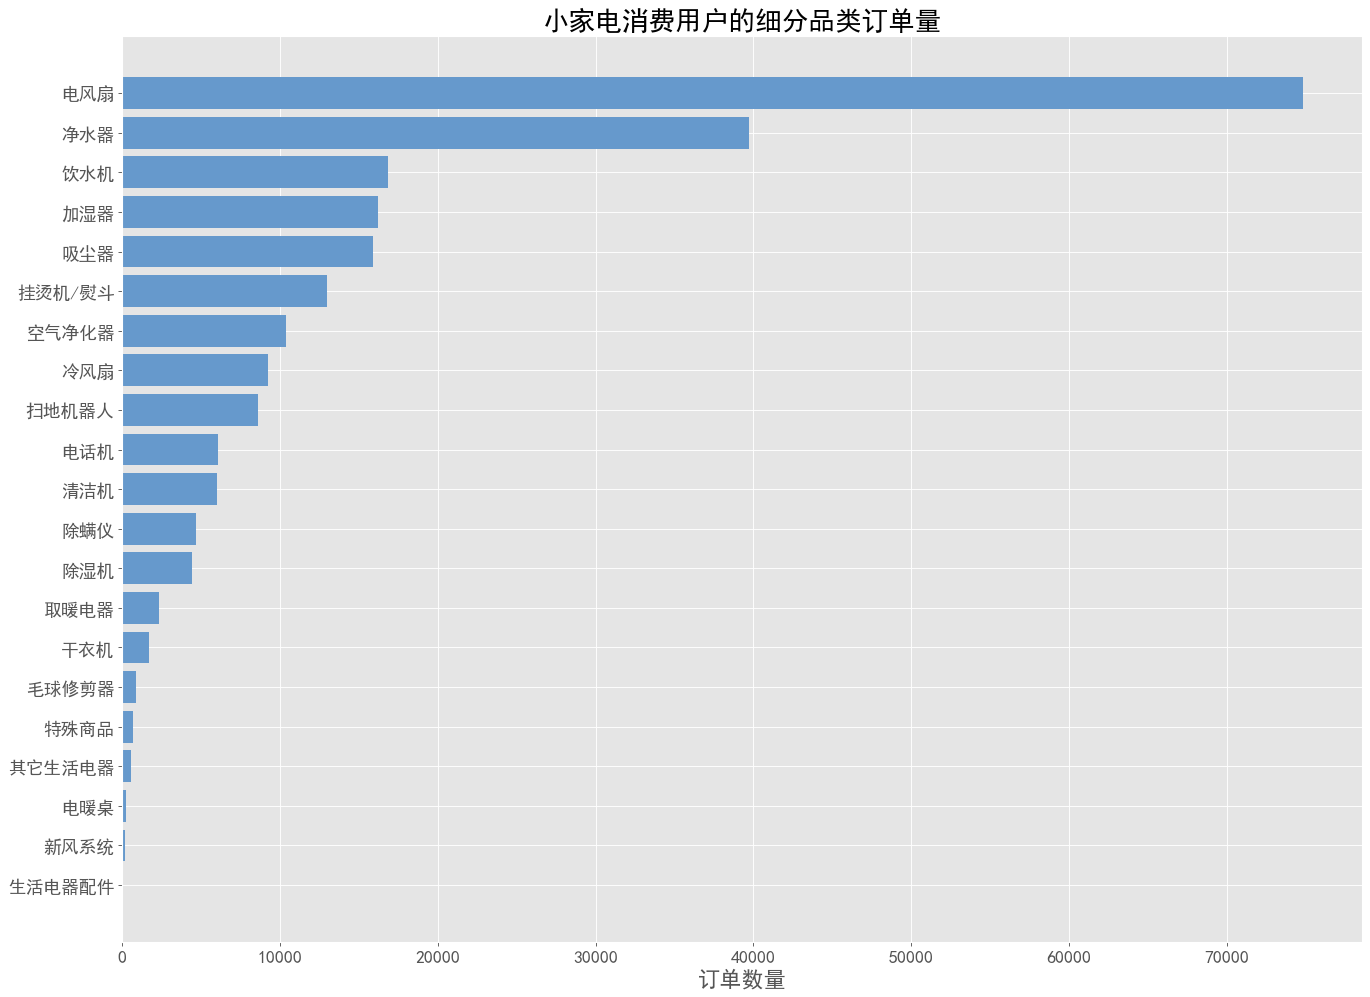

In [70]:
x = user_order_cate_df['item_third_cate_name'][::-1]
y = user_order_cate_df['cate_count'][::-1]

plt.figure(figsize=(20,15),dpi=80)
plt.xlabel('订单数量', size=20)
plt.barh(x, y, align='center', color='#6699CC')
plt.title("小家电消费用户的细分品类订单量", size=24)

plt.xticks(size=16) # x轴字体大小调整
plt.yticks(size=16) # y轴字体大小调整

plt.show()

# 用户价值属性

使用了用户有效订单，vaild_order_user_df

## 是否曾经是plus会员 

In [103]:
plus_user_df = vaild_order_user_df.groupby("ulp_plus_used", as_index = False)["user_log_acct"].agg({"plus_count":"count"})
plus_user_df

,ulp_plus_used,plus_count
0,0,95488
1,1,137111


## 用户价值分组

In [186]:
# 查找所有和cvl相关的variable
cols = vaild_order_user_df.columns
cols = cols.str.extract(r"(cvl_[a-zA-z]+)",expand = True).dropna()
cols

,0
54,cvl_glob_valuegrp
55,cvl_glob_values
56,cvl_glob_loyalty
57,cvl_glob_platform


In [252]:
valuegrp_df = vaild_order_user_df.groupby("cvl_glob_valuegrp",as_index = False)["user_log_acct"].agg({"user_count":"count"})
valuegrp_df = valuegrp_df[valuegrp_df.cvl_glob_valuegrp != "-1"]
valuegrp_df

,cvl_glob_valuegrp,user_count
1,价值中,40157
2,价值低,10080
3,价值高,66129
4,非常高,108916


Text(0.5, 1.0, '小家电消费用户价值分类')

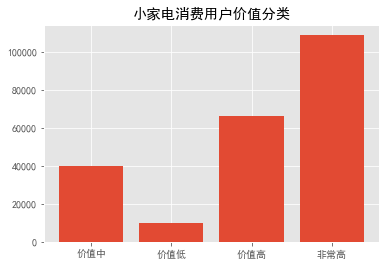

In [210]:
plt.bar(valuegrp_df["cvl_glob_valuegrp"],valuegrp_df["user_count"])
plt.title("小家电消费用户价值分类")

## 用户价值标准得分

In [253]:
user_values = vaild_order_user_df.groupby("cvl_glob_values",as_index = False)["user_log_acct"].agg({"user_count":"count"})
user_values

,cvl_glob_values,user_count
0,-1.0,7317
1,0.1172387,1
2,0.11724689,1
3,0.12468599,2
4,0.124760985,1
...,...,...
175205,9.997724,1
175206,9.997937,1
175207,9.997943,3
175208,9.999206,1


In [265]:
# remove -1
#user_values["cvl_glob_values"] = user_values["cvl_glob_values"].astype(float)
user_values = user_values[user_values.cvl_glob_values >=0]
user_values

,cvl_glob_values,user_count
1,0.117239,1
2,0.117247,1
3,0.124686,2
4,0.124761,1
5,0.126324,1
...,...,...
175205,9.997724,1
175206,9.997937,1
175207,9.997943,3
175208,9.999206,1


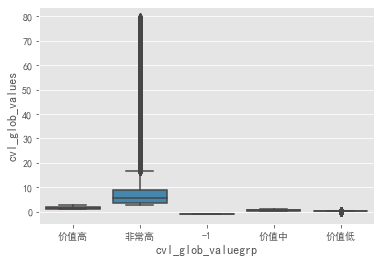

In [266]:
sns.boxplot(x = "cvl_glob_valuegrp", y = "cvl_glob_values",data = vaild_order_user_df)

In [268]:
vaild_order_user_df.groupby(["cvl_glob_valuegrp"], as_index = False)["cvl_glob_values"].max()

,cvl_glob_valuegrp,cvl_glob_values
0,-1,-1.000000
1,价值中,1.000728
2,价值低,0.349877
3,价值高,2.671667
4,非常高,79.807945


In [269]:
vaild_order_user_df.groupby(["cvl_glob_valuegrp"], as_index = False)["cvl_glob_values"].min()

,cvl_glob_valuegrp,cvl_glob_values
0,-1,-1.000000
1,价值中,0.349909
2,价值低,0.117239
3,价值高,1.000807
4,非常高,2.671753


## 用户忠诚度

In [271]:
vaild_order_user_df.cvl_glob_loyalty.nunique()

8

In [278]:
vaild_order_user_df.cvl_glob_loyalty.unique()

array(['高度-忠诚型', '-1', '远期-偶然型', '中度-忠诚型', '近期-普通型', '远期-普通型', '远期-投机型',
       '近期-投机型'], dtype=object)

In [284]:
loyalty_df = vaild_order_user_df.groupby("cvl_glob_loyalty", as_index=False)["user_log_acct"].agg(
    {"type_count": "count"}).sort_values(by="type_count", ascending=False)
loyalty_df

,cvl_glob_loyalty,type_count
7,高度-忠诚型,161200
1,中度-忠诚型,21636
3,近期-普通型,19416
6,远期-普通型,12217
4,远期-偶然型,7777
0,-1,6706
2,近期-投机型,2807
5,远期-投机型,840


In [291]:
loyalty_df = loyalty_df[loyalty_df.cvl_glob_loyalty!="-1"]
loyalty_df["per%"] = loyalty_df["type_count"]/loyalty_df["type_count"].sum()
loyalty_df

,cvl_glob_loyalty,type_count,per%
7,高度-忠诚型,161200,0.713612
1,中度-忠诚型,21636,0.095780
3,近期-普通型,19416,0.085952
6,远期-普通型,12217,0.054083
4,远期-偶然型,7777,0.034428
2,近期-投机型,2807,0.012426
5,远期-投机型,840,0.003719


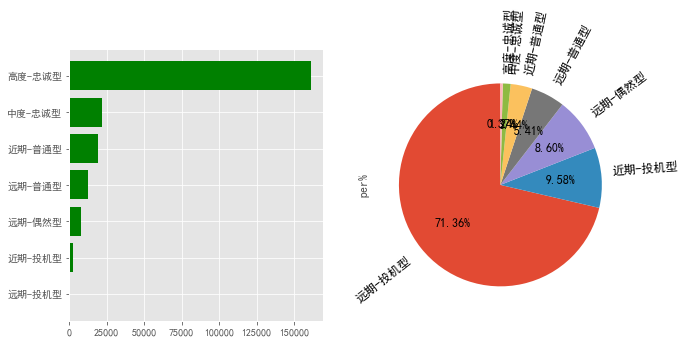

In [325]:
x = loyalty_df["cvl_glob_loyalty"][::-1]
y1 = loyalty_df["type_count"][::-1]

# visualization

plt.figure(figsize = (10,5))

plt.subplot(121)
plt.barh(y = x, width = y1,color = "g")


plt.subplot(122)
loyalty_df["per%"].plot.pie(labels = x, autopct = "%1.2f%%",startangle = 90, textprops = {"fontsize":12},rotatelabels = True)
#plt.pie(y1, labels = x, autopct = "%1.2f%%",startangle = 90, textprops = {"fontsize":12},rotatelabels = True)


## 平台影响力

In [333]:
platform_df = vaild_order_user_df.groupby("cvl_glob_platform",as_index = False)["user_log_acct"].agg({"platform":"count"})
platform_df = platform_df[platform_df.cvl_glob_platform>=0]
platform_df

,cvl_glob_platform,platform
1,4.784754,1
2,6.471939,1
3,6.825068,1
4,6.966445,1
5,7.047620,2
...,...,...
88337,99.892613,1
88338,99.919297,1
88339,99.923220,1
88340,99.931090,1


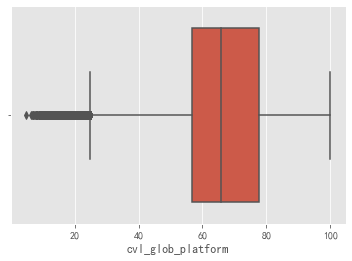

In [336]:
sns.boxplot(platform_df.cvl_glob_platform)

## 用户价值小结

典型的小家电消费者**（现在或）曾经是plus会员**，有**非常高的用户价值**（但价值标准得分存在很大差异）；

他是**高度-忠诚型**用户，有比较高的平台影响力。

*************

**结论**

促销时可以针对会员进行推送，对用户价值高的消费者，挖掘他们的兴趣爱好以及对应的商品分类，推送合适的活动、给予合适的价格；

因为他们的平台影响力高，更应该推送高质量商品，从正面引导其他用户消费。